In [1]:
import json
from pystac import Catalog, get_stac_version

root_catalog = Catalog.from_file('https://s3.ecodatacube.eu/arco/stac/catalog.json')
print(f"ID: {root_catalog.id}")
print(f"Title: {root_catalog.title or 'N/A'}")
print(f"Description: {root_catalog.description or 'N/A'}")


ID: stac
Title: EcoDataCube
Description: Spatio-Temporal Asset Catalog for European-wide layers provided by [EcoDataCube](http://EcoDataCube.eu).


In [2]:
collections = list(root_catalog.get_collections())
print(f"Number of collections: {len(collections)}")

# root_catalog.describe()

Number of collections: 162


In [22]:
ndvi_collection = []
for icol in collections:
    if 'NDVI' in icol.description:
        ndvi_collection.append(icol)

print(f"Number of NDVI relevant collections: {len(ndvi_collection)}")


Number of NDVI relevant collections: 7


In [72]:
import shapely.geometry as geom
from shapely.geometry import Polygon
import geopandas as gpd

# eg: Wageningen polygon ~ (5.666, 51.966)
wageningen_poly = geom.Polygon([
    (5.65, 51.95),
    (5.68, 51.95),
    (5.68, 51.98),
    (5.65, 51.98),
    (5.65, 51.95)
])

gdf = gpd.GeoDataFrame({"id": [1]}, geometry=[wageningen_poly], crs="EPSG:4326")


wageningen_collection = []

for icol in collections:
    bbox = icol.extent.spatial.bboxes[0]

    collection_extent = Polygon([
        (bbox[0], bbox[1]),  # lower-left
        (bbox[2], bbox[1]),  # lower-right
        (bbox[2], bbox[3]),  # upper-right
        (bbox[0], bbox[3]),  # upper-left
        (bbox[0], bbox[1])   # close polygon
    ])

    if collection_extent.contains(gdf.iloc[0].geometry):
        wageningen_collection.append(icol)

print(f"Number of collections covering Wageningen: {len(wageningen_collection)}")


Number of collections covering Wageningen: 162


In [46]:
from datetime import datetime, timezone

# make the test date timezone-aware in UTC
# so that it's consistent with collection time stamp
date_to_check = datetime(2022, 1, 1, tzinfo=timezone.utc)

collection_20220101 = []

for icol in collections:
    start, end = icol.extent.temporal.intervals[0]
    
    is_covered = start <= date_to_check <= end

    if is_covered:
        collection_20220101.append(icol)

print("Number of collections covering 2022-01-01:", len(collection_20220101))


Number of collections covering 2022-01-01: 60


In [52]:
ndvi_trend_collection = []
for icol in collections:
    if 'NDVI' in icol.description:
        if 'Slope' in icol.description:
            ndvi_trend_collection.append(icol)

print(f"Number of NDVI-trend relevant collections: {len(ndvi_trend_collection)}")

print(f"ID: {ndvi_trend_collection[0].id}")
print(f"Title: {ndvi_trend_collection[0].title or 'N/A'}")
print(f"Description: {ndvi_trend_collection[0].description or 'N/A'}")


Number of NDVI-trend relevant collections: 1
ID: ndvi_glad.landsat.ard2.seasconv.yearly.m.theilslopes
Title: Cloud-free reconstructed Landsat long-term trend of Normalized Difference Vegetation Index (NDVI)
Description: Slope fiited with Theil-Sen estimator on annual NDVI time series between 2000 and 2022.


In [ ]:
ndvi_trend_collection[0].links

[<Link rel=root target=<Catalog id=stac>>,
 <Link rel=item target=./ndvi_glad.landsat.ard2.seasconv.yearly.m.theilslopes_20000101_20221231/ndvi_glad.landsat.ard2.seasconv.yearly.m.theilslopes_20000101_20221231.json>,
 <Link rel=self target=https://s3.ecodatacube.eu/arco/stac/ndvi_glad.landsat.ard2.seasconv.yearly.m.theilslopes/collection.json>,
 <Link rel=parent target=<Catalog id=stac>>]

In [64]:
import pystac
ndvi_trend_item = pystac.read_file(ndvi_trend_collection[0].links[1])
ndvi_trend_item.assets

{'ndvi_glad.landsat.ard2.seasconv.yearly.m.theilslopes_m_30m_s': <Asset href=https://s3.ecodatacube.eu/arco/ndvi_glad.landsat.ard2.seasconv.yearly.m.theilslopes_m_30m_s_20000101_20221231_eu_epsg.3035_v20231218.tif>,
 'sld': <Asset href=https://s3.ecodatacube.eu/arco/ndvi_glad.landsat.ard2.seasconv.yearly.m.theilslopes.sld>,
 'qml': <Asset href=https://s3.ecodatacube.eu/arco/ndvi_glad.landsat.ard2.seasconv.yearly.m.theilslopes.qml>,
 'thumbnail': <Asset href=https://s3.ecodatacube.eu/arco/stac/ndvi_glad.landsat.ard2.seasconv.yearly.m.theilslopes/ndvi_glad.landsat.ard2.seasconv.yearly.m.theilslopes_20000101_20221231/ndvi_glad.landsat.ard2.seasconv.yearly.m.theilslopes_m_30m_s_20000101_20221231_eu_epsg.3035_v20231218.png>}

In [74]:
src.crs

CRS.from_wkt('PROJCS["ETRS89-extended / LAEA Europe",GEOGCS["ETRS89",DATUM["European_Terrestrial_Reference_System_1989",SPHEROID["GRS 1980",6378137,298.257222101,AUTHORITY["EPSG","7019"]],AUTHORITY["EPSG","6258"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","4258"]],PROJECTION["Lambert_Azimuthal_Equal_Area"],PARAMETER["latitude_of_center",52],PARAMETER["longitude_of_center",10],PARAMETER["false_easting",4321000],PARAMETER["false_northing",3210000],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Northing",NORTH],AXIS["Easting",EAST],AUTHORITY["EPSG","3035"]]')

S3 url: https://s3.ecodatacube.eu/arco/ndvi_glad.landsat.ard2.seasconv.yearly.m.theilslopes_m_30m_s_20000101_20221231_eu_epsg.3035_v20231218.tif


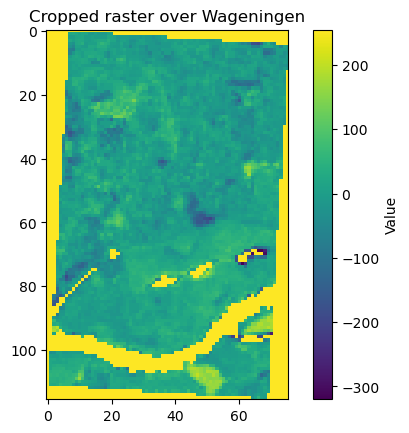

In [78]:
import rasterio
from rasterio.mask import mask
from shapely.geometry import mapping
import matplotlib.pyplot as plt

# get url from item asset link
asset_url = ndvi_trend_item.assets.get('ndvi_glad.landsat.ard2.seasconv.yearly.m.theilslopes_m_30m_s').href
print('S3 url:', asset_url)

# open raster directly from S3 (requires rasterio with HTTP enabled, which is default)
with rasterio.open(asset_url) as src:
    gdf_proj = gdf.to_crs(src.crs)
    # crop the raster with the polygon
    out_image, out_transform = mask(src, [mapping(gdf_proj.geometry[0])], crop=True)
    out_meta = src.meta.copy()

# plot the cropped raster
plt.imshow(out_image[0], cmap="viridis")
plt.title("Cropped raster over Wageningen")
plt.colorbar(label="Value")
plt.show()
